In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn import metrics

In [2]:
#Sampling 20,000 data entries
#n = 609846
#s = 40000
#skip = sorted(random.sample(range(1,n+1),n-s))
#data = pd.read_csv('data.csv', skiprows=skip)
#data

In [3]:
data = pd.read_csv('data.csv')

In [4]:
# Dropping columns not needed for this test
data = data.drop(columns=['Name', 'AgeClass',                          'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
                          'Place', 'Tested',
                          'Date', 'TotalKg', 'Squat1Kg',
                          'Squat2Kg', 'Squat3Kg','Bench1Kg', 'Bench2Kg',
                          'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                          'Deadlift3Kg', 'McCulloch', 'Wilks',
                          'WeightClassKg'])

data.columns
data.isnull().sum()

Sex                     0
Event                   0
Equipment               0
Age                     0
BodyweightKg            0
Best3SquatKg       211827
Best3BenchKg        39260
Best3DeadliftKg    163726
Glossbrenner         1223
dtype: int64

In [5]:
# Dropping athletes who did not compete in complete SBD competitions
indexNames = data[data['Event'] == 'S'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'B'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'D'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SD'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SB'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'BD'].index
data.drop(indexNames, inplace=True)
data

,Sex,Event,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Glossbrenner
0,F,SBD,Wraps,29.0,59.8,105.0,55.0,130.0,286.42
1,F,SBD,Wraps,29.0,58.5,120.0,67.5,145.0,334.16
3,F,SBD,Wraps,23.0,60.0,105.0,72.5,132.5,305.37
4,F,SBD,Wraps,45.0,104.0,140.0,80.0,170.0,274.56
5,F,SBD,Wraps,37.0,74.0,142.5,82.5,145.0,312.20
...,...,...,...,...,...,...,...,...,...
609841,M,SBD,Raw,65.5,78.0,215.0,115.0,207.5,360.48
609842,M,SBD,Raw,67.5,72.7,200.0,70.0,235.0,356.14
609843,M,SBD,Raw,60.5,73.5,175.0,87.5,190.0,316.52
609844,M,SBD,Raw,55.5,63.5,110.0,95.0,170.0,295.66


In [6]:
# Dropping the remaining nulls. Around 0.2% of the dataset
data.isnull().sum()

Sex                  0
Event                0
Equipment            0
Age                  0
BodyweightKg         0
Best3SquatKg       601
Best3BenchKg       613
Best3DeadliftKg    597
Glossbrenner       822
dtype: int64

In [7]:
data = data.dropna()

In [8]:
# Convert string data to numeric
sex = {'M': 1, 'F': 0, 'Mx': 3}
equipment = {'Raw': 0, 'Wraps': 1, 'Multi-ply': 2, 'Single-ply': 3, 'Straps': 4}

data.Sex = [sex[item] for item in data.Sex]
data.Equipment = [equipment[item] for item in data.Equipment]

/usr/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
# Normalise the data, scaling to values between 0-1
scaler = MinMaxScaler(feature_range=(0,1))
data[['Sex', 'Age','Equipment', 'BodyweightKg',
        'Glossbrenner', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']] = scaler.fit_transform(data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Glossbrenner', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']])

<ipython-input-9-53bfdb86bf2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Sex', 'Age','Equipment', 'BodyweightKg',
/usr/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# So, running 3 different test and training sets.
# First for squats, then bench, finally deadlifts,
# See the model accuracy for predicting someone's lifts.
# Further experiments to see which variables are critical
# to accurate prediction. How accurate can we get with age,
# sex, weight, and equipment?

test_data = data[['Sex', 'BodyweightKg', 'Equipment', 'Glossbrenner']]

target_squat = data[['Best3SquatKg']]

target_bench = data[['Best3BenchKg']]

target_dead = data[['Best3DeadliftKg']]

In [11]:
#Prepare the sets
X = test_data
s = target_squat
b = target_bench
d = target_dead

In [12]:
# Split sets into training and test sets
X_train, X_test, s_train, s_test = train_test_split(X, s, test_size=0.3, random_state=3)
X_train, X_test, b_train, b_test = train_test_split(X, b, test_size=0.3, random_state=3)
X_train, X_test, d_train, d_test = train_test_split(X, d, test_size=0.3, random_state=3)

In [13]:
# Prepare random forest models, check r2_scores.
srfregr = RandomForestRegressor(n_estimators=10, max_depth = 15, bootstrap=True)
brfregr = RandomForestRegressor(n_estimators=10, max_depth = 15, bootstrap=True)
drfregr = RandomForestRegressor(n_estimators=10, max_depth = 15, bootstrap=True)

In [14]:
srfregr.fit(X_train, s_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [15]:
S_rfr = srfregr.predict(X_test)
print("Test R2-score: %.2f" % r2_score(S_rfr , s_test))
print("Test RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(s_test, S_rfr)))
print("Test Std: %.2f" % s_test.std())

S_rfr1 = srfregr.predict(X_train)
print("Train R2-score: %.2f" % r2_score(S_rfr1 , s_train))
print("Train RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(s_train, S_rfr1)))
print("Train Std: %.2f" % s_train.std())

Test R2-score: 0.96
Test RMSE: 0.02
Test Std: 0.09
Train R2-score: 0.97
Train RMSE: 0.01
Train Std: 0.09


In [16]:
features = ['Sex','BodyweightKg', 'Equipment', 'Glossbrenner']
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 3), srfregr.feature_importances_), features), 
             reverse=True))

Features sorted by their score:
[(0.667, 'Glossbrenner'), (0.201, 'BodyweightKg'), (0.128, 'Sex'), (0.004, 'Equipment')]


In [17]:
brfregr.fit(X_train, b_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [18]:
B_rfr = brfregr.predict(X_test)
print("R2-score: %.2f" % r2_score(B_rfr , b_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(b_test, B_rfr)))
print("Std: %.2f" % b_test.std())

R2-score: 0.90
RMSE: 0.02
Std: 0.08


In [19]:
drfregr.fit(X_train, d_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [20]:
D_rfr = drfregr.predict(X_test)
print("R2-score: %.2f" % r2_score(D_rfr , d_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(d_test, D_rfr)))
print("Std: %.2f" % d_test.std())

R2-score: 0.93
RMSE: 0.04
Std: 0.14


In [21]:
#Prepare Lineaar models and check r2_scores
S_linreg = LinearRegression()
B_linreg = LinearRegression()
D_linreg = LinearRegression()

In [22]:
S_linreg.fit(X_train, s_train.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
S_lin = S_linreg.predict(X_test)
print("Test R2-score: %.2f" % r2_score(S_lin , s_test))
print("Test RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(s_test, S_lin)))
print("Test Std: %.2f" % s_test.std())

S_lin1 = S_linreg.predict(X_train)
print("Train R2-score: %.2f" % r2_score(S_lin1, s_train))
print("Train RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(s_train, S_lin1)))
print("Train Std: %.2f" % s_train.std())

Test R2-score: 0.93
Test RMSE: 0.02
Test Std: 0.09
Train R2-score: 0.93
Train RMSE: 0.02
Train Std: 0.09


In [24]:
B_linreg.fit(X_train, b_train.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
B_lin = B_linreg.predict(X_test)
print("R2-score: %.2f" % r2_score(B_lin , b_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(b_test, B_lin)))
print("Std: %.2f" % b_test.std())

R2-score: 0.87
RMSE: 0.03
Std: 0.08


In [26]:
D_linreg.fit(X_train, d_train.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
D_lin = D_linreg.predict(X_test)
print("R2-score: %.2f" % r2_score(D_lin , d_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(d_test, D_lin)))
print("Std: %.2f" % d_test.std())

R2-score: 0.89
RMSE: 0.04
Std: 0.14


In [28]:
sfr_pred = pd.DataFrame(srfregr.predict(X_test))

slr_pred = pd.DataFrame(S_linreg.predict(X_test))


S_bw = pd.DataFrame(X_test['BodyweightKg'])
S_bw = S_bw.reset_index()
S_bw = S_bw.drop(columns = 'index')

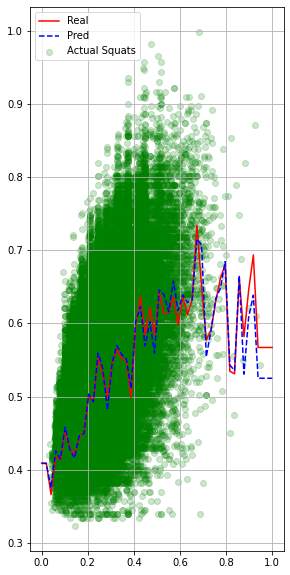

In [29]:
# Visualizing the data points in the random forest
#
xfit = np.linspace(0, 1)
yfit = RandomForestRegressor().fit(S_bw, sfr_pred.values.ravel()).predict(xfit[:, None])
zfit = RandomForestRegressor().fit(S_bw, s_test.values.ravel()).predict(xfit[:, None])
plt.figure(figsize=(10,10))

plt.subplot(1 , 2, 1)
plt.scatter(S_bw, s_test, color = 'green', label='Actual Squats', alpha=0.2)
plt.plot(xfit, np.sin(zfit),'red', label='Real');
plt.plot(xfit, np.sin(yfit),'b--', label='Pred');
plt.legend()
plt.grid(True)


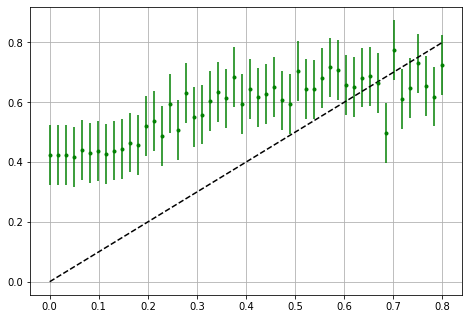

In [38]:
# Visualising the error bars for the random forest
xfit = np.linspace(0, 0.8)
yfit = RandomForestRegressor().fit(S_bw, sfr_pred.values.ravel()).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.errorbar(xfit, yfit, 0.1, fmt='.g')
plt.plot([0,0.8], [0,0.8], 'k--')
ax.grid(True)
plt.show()

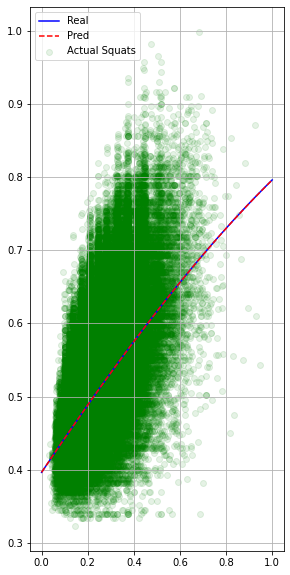

In [31]:
xfit = np.linspace(0, 1)
yfit = LinearRegression().fit(S_bw, slr_pred).predict(xfit[:, None])
zfit = LinearRegression().fit(S_bw, s_test).predict(xfit[:, None])
plt.figure(figsize=(10,10))

plt.subplot(1 , 2, 1)
plt.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.1)
plt.plot(xfit, np.sin(zfit), 'b', label='Real');
plt.plot(xfit, np.sin(yfit), 'r--', label='Pred');
plt.legend()
plt.grid(True)

plt.show()

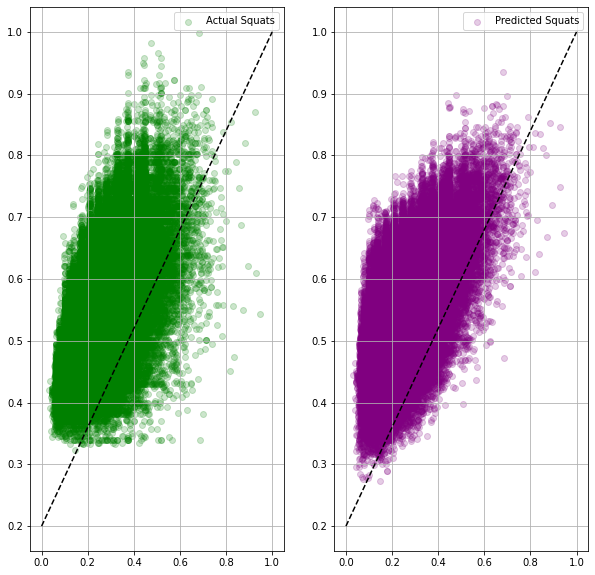

In [32]:
# Visualising the difference between the actual squats, and the 
# predicted squats
xfit = np.linspace(0, 1)
yfit = LinearRegression().fit(S_bw, slr_pred).predict(xfit[:, None])
zfit = LinearRegression().fit(S_bw, s_test).predict(xfit[:, None])
plt.figure(figsize=(10,10))

plt.subplot(1 , 2, 1)
plt.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
plt.plot([0,1], [0.2,1], 'k--')
plt.legend()
plt.grid(True)

plt.subplot(1 , 2, 2)
plt.scatter(S_bw, slr_pred, color = 'purple', label='Predicted Squats', alpha=0.2)
plt.plot([0,1], [0.2,1], 'k--')
plt.legend()
plt.grid(True)

ax.grid(True)
plt.show()

<ipython-input-33-42200e2ee52f>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  zfit = RandomForestRegressor().fit(S_bw, s_test).predict(xfit[:, None]).ravel()


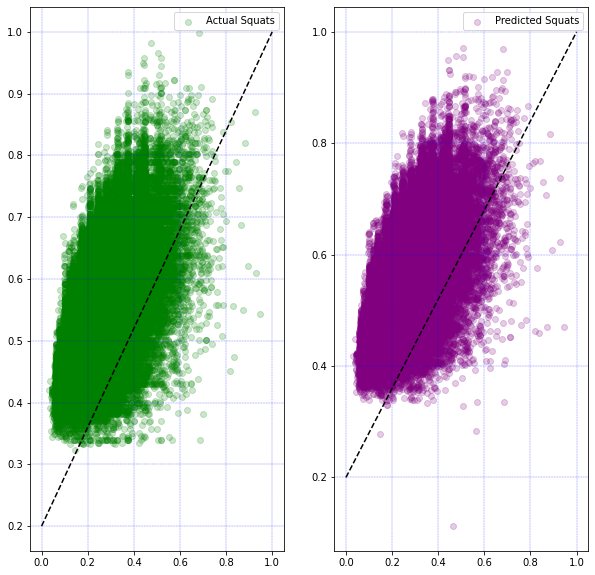

In [33]:
# Visualising the difference between the actual squats, and the 
# predicted squats
xfit = np.linspace(0, 1)
yfit = RandomForestRegressor().fit(S_bw, S_rfr).predict(xfit[:, None]).ravel()
zfit = RandomForestRegressor().fit(S_bw, s_test).predict(xfit[:, None]).ravel()
plt.figure(figsize=(10,10))

plt.subplot(1 , 2, 1)
plt.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
plt.plot([0,1], [0.2,1], 'k--')
plt.legend()
plt.grid(True, color='b', ls = '-.', lw = 0.25)

plt.subplot(1 , 2, 2)
plt.scatter(S_bw, S_rfr, color = 'purple', label='Predicted Squats', alpha=0.2)
plt.plot([0,1], [0.2,1], 'k--')
plt.legend()
plt.grid(True, color='b', ls = '-.', lw = 0.25)

ax.grid(True)
plt.show()

In [34]:
training_sizes = [1, 500, 2000, 5000, 7500, 10000, 15000, 19000]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = X,
y = s, train_sizes = training_sizes,cv = 100,
scoring = 'neg_root_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print(train_scores_mean)
print(validation_scores_mean)

[-0.          0.02335749  0.02061828  0.02093643  0.02094761  0.02074894
  0.02122703  0.02136969]
[0.13455081 0.02637367 0.02666727 0.02631927 0.02309866 0.02281706
 0.02261679 0.02246313]


(0.0, 15000.0)

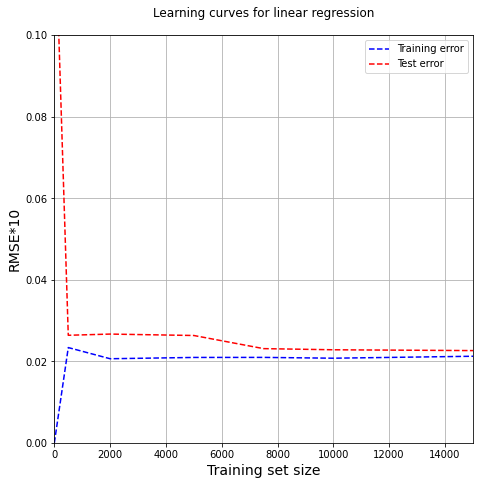

In [35]:
plt.figure(figsize=(7.5,7.5))
plt.plot(train_sizes, train_scores_mean, 'b--', label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, 'r--', label = 'Test error')
plt.ylabel('RMSE*10', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for linear regression', fontsize = 12, y = 1.03)
plt.grid(True)
plt.legend()
plt.ylim(0, 0.1)
plt.xlim(0, 15000)